# ¿Quién llegará al número uno en Billboard 100?

A partir de atributos de cantantes y de un histórico de canciones que alcanzaron entrar al Billboard 100 (U.S.) en 2013 y 2014 se creará un árbol de decisión permita intentar predecir si un nuevo cantante podrá llegar a número uno.

In [1]:
# Imports necesarios
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

## Cargamos los datos de entrada

In [2]:
artists_billboard = pd.read_csv(r'artists_billboard_fix3.csv')


In [3]:
artists_billboard.shape

(635, 11)

Datos de 635 artistas con 11 atributos

In [4]:
artists_billboard.head(5)

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0


¿Cuántos alcanzaron el número 1?

In [5]:
artists_billboard.groupby('top').size()

top
0    494
1    141
dtype: int64

494 canciones que no alcanzaron el top 1 y 141 que si, lo que significa que los datos están desbalanceados

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


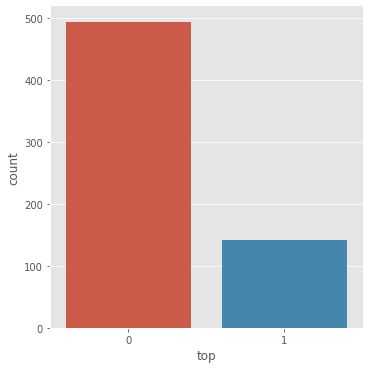

In [77]:
sb.factorplot('top',data=artists_billboard,kind="count")

 Visualizar los Atributos de entrada

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


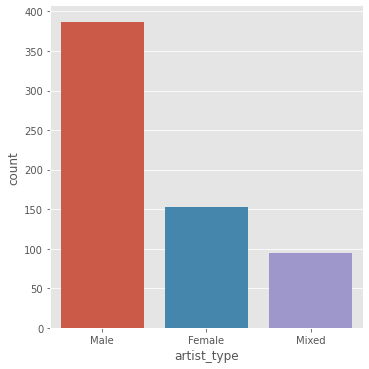

In [78]:
sb.factorplot('artist_type',data=artists_billboard,kind="count")

Se evidencia que hay más del doble de artistas masculinos que femeninos, mientras que sólo hay alrededor de 100 mixtas

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


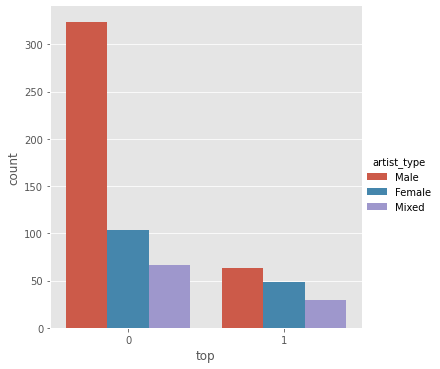

In [79]:
sb.factorplot('top',data=artists_billboard,hue='artist_type',kind="count")

Y ademas que la gran mayoría de esas canciones con artistas hombres no alcanzaron el top 1 de billboard (U.S.)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


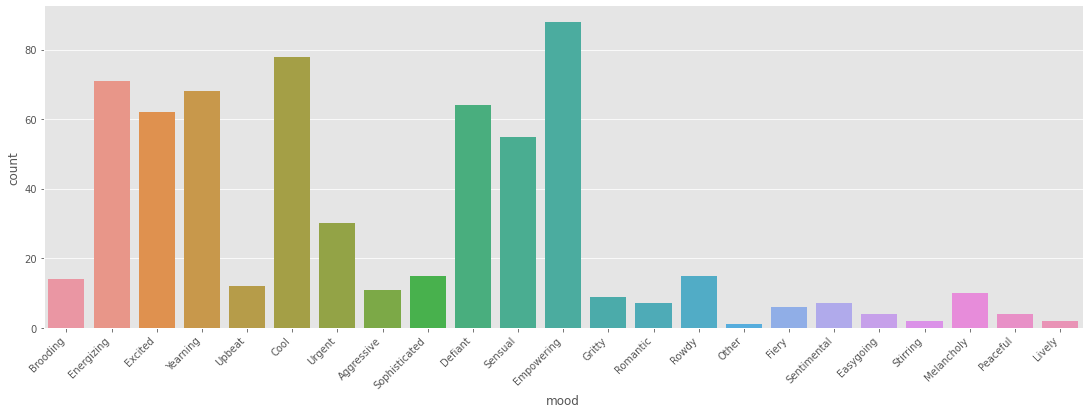

In [80]:
g = sb.factorplot('mood',data=artists_billboard,kind="count", aspect=3)

for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right') 

De 23 tipos de "mood" hay 7 con mayor cantidad de datos:
 - Energizing
 - Excited
 - Yeaming
 - Cool
 - Defiant
 - Sensual
 - Empowering


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


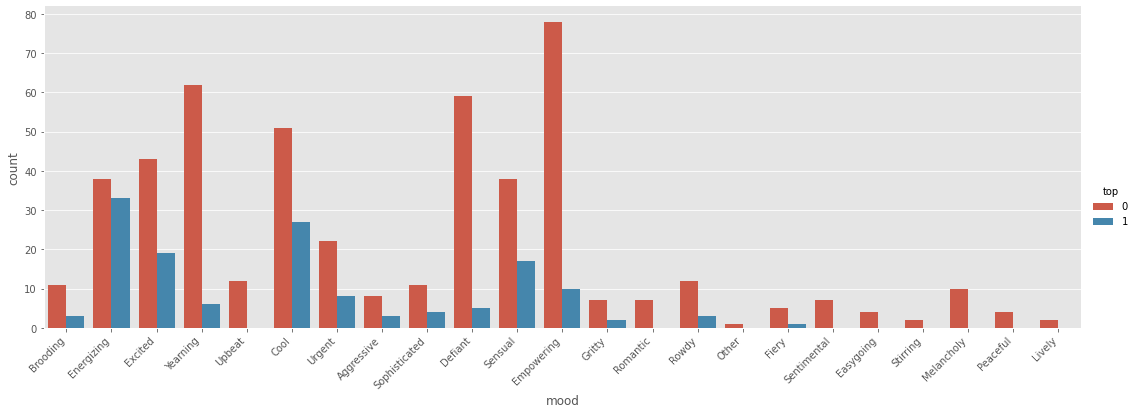

In [81]:
g = sb.factorplot('mood',data=artists_billboard,hue='top',kind="count", aspect=3)

for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right') 

El mood "yeaming", "defiant" y "empowering" son de los que menos canciones en top 1 han alcanzado de esos 7, mientras "cool" y "energizing" son de los que mas canciones en top 1 tuvieron

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


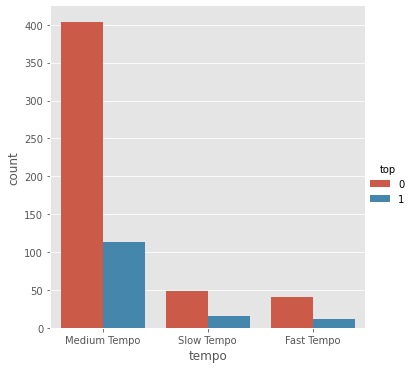

In [82]:
sb.factorplot('tempo',data=artists_billboard,hue='top',kind="count")

Se ven 3 tipos de "tempo"
 - Medium
 - Slow
 - Fast

Predominando el "tempo" medium para todas las canciones y también para las que han alcanzado el top 1 (azul) 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


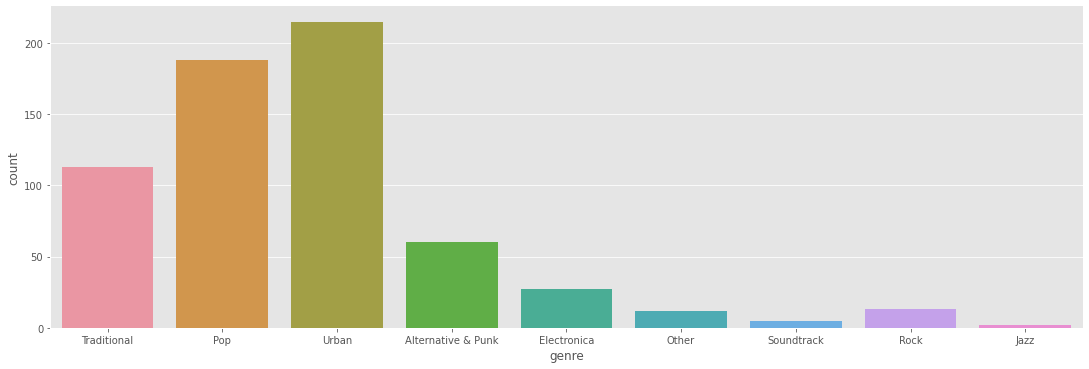

In [83]:
sb.factorplot('genre',data=artists_billboard,kind="count", aspect=3)

Por el genero de la musica se ve que predominan el Urban y el Pop seguidos por el Tradicional

Visualizar los años de nacimiento de los artistas

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


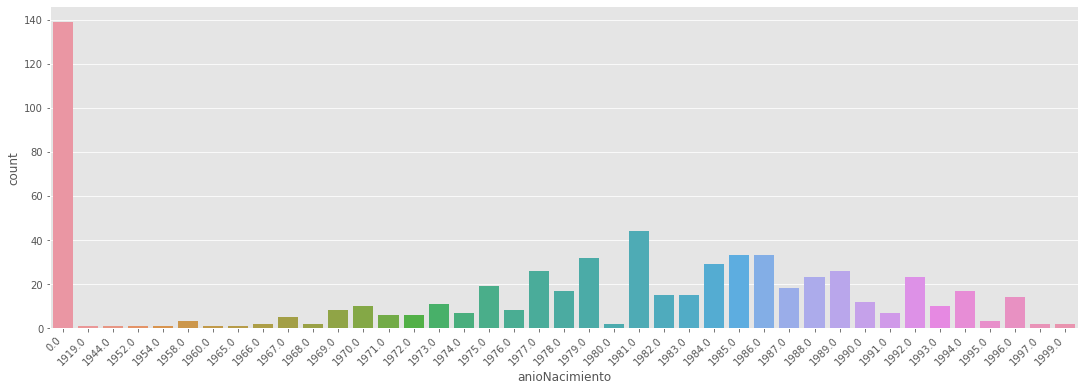

In [84]:
g = sb.factorplot('anioNacimiento',data=artists_billboard,kind="count", aspect=3)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right') 

En el año "0" de nacimiento del artista hay aproximadamente 140 registros

In [85]:
#artists_billboard[['anioNacimiento', 'top']].groupby(['anioNacimiento'], as_index=False).agg(['mean', 'count', 'sum'])
nacimientosPorAnio = artists_billboard['anioNacimiento']
len(nacimientosPorAnio[nacimientosPorAnio<=0])

139

Se tienen 139 registros de canciones de las que se desconoce el año de nacimiento del artista. Se deben tratar estos datos para poder utilizar el árbol.

# Comparemos los Top y los No-top

Buscar si hay alguna relación evidente entre Año y duración de Canción

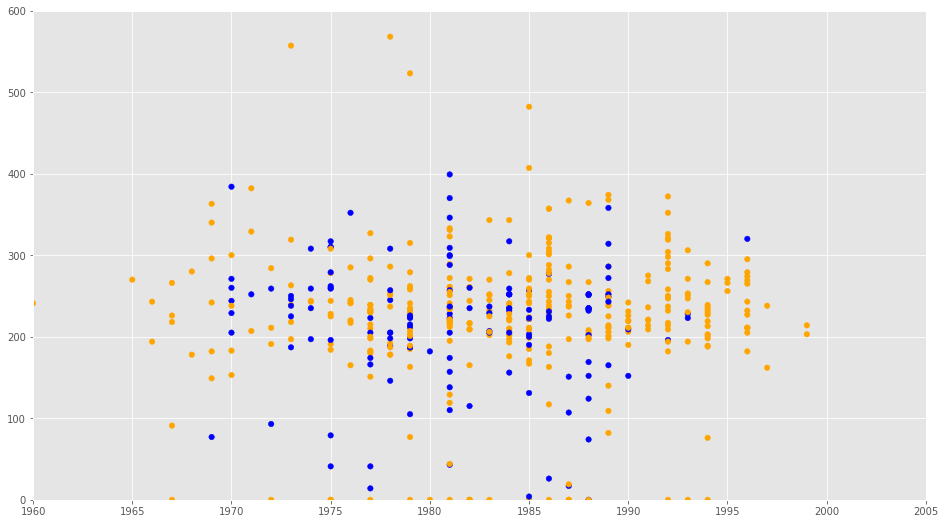

In [86]:
colores=['orange','blue']
tamanios=[60,40]

f1 = artists_billboard['anioNacimiento'].values
f2 = artists_billboard['durationSeg'].values

asignar=[]
for index, row in artists_billboard.iterrows():    
    asignar.append(colores[row['top']])

plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([1960,2005,0,600])
plt.show()

No perece haber ningún patron a la vista, están bastante mezclados los top de los no-top.

Analizar en que años se tienen las Top

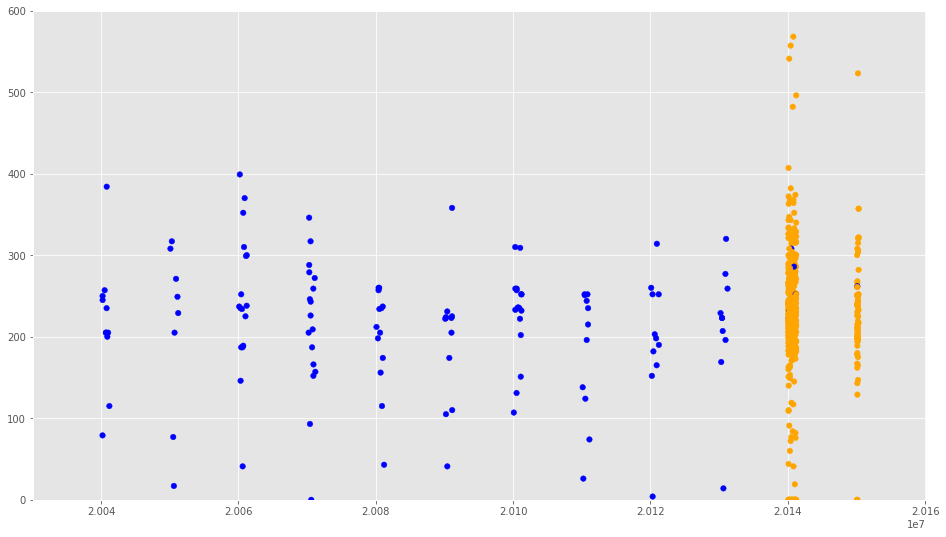

In [87]:
f1 = artists_billboard['chart_date'].values
f2 = artists_billboard['durationSeg'].values

asignar=[]
asignar2=[]
for index, row in artists_billboard.iterrows():    
    asignar.append(colores[row['top']])
    asignar2.append(tamanios[row['top']])

plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([20030101,20160101,0,600])
plt.show()

Esto es porque inicialmente se tomó información de 2014 y 2015 y había casi 500 no-top contra sólo 11 registros top.

Entonces se agrupan a los artistas que alcanzaron el top entre 2004 y 2013 para sumar casos positivos y equilibrar un poco nuestros datos de entrada. Aún así siguen estando desbalanceados los datos.

Por lo tanto se usará un parametro (class_weight) del algoritmo de árbol de decisión para compensar la diferencia.

## Arreglar las Edades de Artistas

El objetivo de tener el año de nacimiento del artista para conocer la edad que tenía al momento de alcanzar el top de billboard.

In [88]:
def edad_fix(anio):
    if anio==0:
        return None
    return anio

artists_billboard['anioNacimiento']=artists_billboard.apply(lambda x: edad_fix(x['anioNacimiento']), axis=1);

Cambiar los valores de "0" por "NaN" en el dataframe

In [89]:
artists_billboard.head(10)

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,NaN
5,5,Where Is At (Yep Yep),DUSTIN LYNCH,Upbeat,Medium Tempo,Traditional,Male,20140531,219.0,0,1990.0
6,6,Single Ladies (Put A Ring On It),BEYONCE,Cool,Slow Tempo,Urban,Female,20081213,43.0,1,1981.0
7,7,Me And My Broken Heart,RIXTON,Urgent,Fast Tempo,Pop,Male,20140412,557.0,0,1973.0
8,8,I Luh Ya Papi,JENNIFER LOPEZ featuring FRENCH MONTANA,Aggressive,Medium Tempo,Urban,Female,20140329,182.0,0,1969.0
9,9,Chocolate,THE 1975,Yearning,Medium Tempo,Alternative & Punk,Male,20140208,347.0,0,NaN


In [90]:
def calcula_edad(anio,cuando):
    cad = str(cuando)
    momento = cad[:4]
    if anio==0.0:
        return None
    return int(momento) - anio

artists_billboard['edad_en_billboard']=artists_billboard.apply(lambda x: calcula_edad(x['anioNacimiento'],x['chart_date']), axis=1);

Añadiendole un campo al dataframe "edad_en_billboard" que se llena con el calculo de la edad que tenía el artista al llegar al top 1

In [91]:
artists_billboard.head(10)

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0,39.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0,25.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0,21.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0,25.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,NaN,NaN
5,5,Where Is At (Yep Yep),DUSTIN LYNCH,Upbeat,Medium Tempo,Traditional,Male,20140531,219.0,0,1990.0,24.0
6,6,Single Ladies (Put A Ring On It),BEYONCE,Cool,Slow Tempo,Urban,Female,20081213,43.0,1,1981.0,27.0
7,7,Me And My Broken Heart,RIXTON,Urgent,Fast Tempo,Pop,Male,20140412,557.0,0,1973.0,41.0
8,8,I Luh Ya Papi,JENNIFER LOPEZ featuring FRENCH MONTANA,Aggressive,Medium Tempo,Urban,Female,20140329,182.0,0,1969.0,45.0
9,9,Chocolate,THE 1975,Yearning,Medium Tempo,Alternative & Punk,Male,20140208,347.0,0,NaN,NaN


Calcular promedio de edad y asignarlos a los registros Nulos

In [92]:
age_avg = artists_billboard['edad_en_billboard'].mean()
age_std = artists_billboard['edad_en_billboard'].std()
age_null_count = artists_billboard['edad_en_billboard'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

conValoresNulos = np.isnan(artists_billboard['edad_en_billboard'])

artists_billboard.loc[conValoresNulos, 'edad_en_billboard'] = age_null_random_list
artists_billboard['edad_en_billboard'] = artists_billboard['edad_en_billboard'].astype(int)
print("Edad Promedio: " + str(age_avg))
print("Desvió Std Edad: " + str(age_std))
print("Intervalo para asignar edad aleatoria: " + str(int(age_avg - age_std)) + " a " + str(int(age_avg + age_std)))

Edad Promedio: 30.10282258064516
Desvió Std Edad: 8.40078832861513
Intervalo para asignar edad aleatoria: 21 a 38


Visualizar las edades agregadas

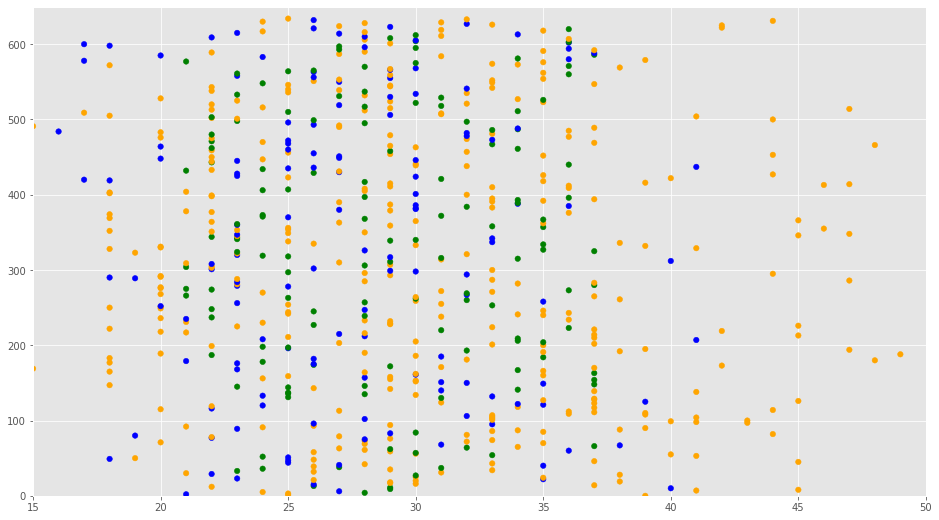

In [93]:
f1 = artists_billboard['edad_en_billboard'].values
f2 = artists_billboard.index

colores = ['orange','blue','green']

asignar=[]
for index, row in artists_billboard.iterrows():    
    if (conValoresNulos[index]):
        asignar.append(colores[2]) # verde
    else:
        asignar.append(colores[row['top']])

plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([15,50,0,650])
plt.show()

Graficando los artistas por edad vs indice se puede ver los colores azul como los que alcanzaron el top billboard mientras que los naranja son los que no lo alcanzaron, los verdes son los que llenados anteriormente con el promedio usando la desviacion estandar

# Mapeo de Atributos

Realizar un mapeo de los atributos de entrada para poder transformarlos a categorias que se puedan utilzar en el árbol de decisión 

In [94]:
separador = "### ### ###"
grouped11 = artists_billboard.groupby('mood').size()
neworder11 = grouped11.sort_values(ascending=False)
print(neworder11)
print(separador)
print("Tempos de Canción: " + str(artists_billboard['tempo'].unique()))
print(separador)
print("Tipos de Artista: " + str(artists_billboard['artist_type'].unique()))
print(separador)
grouped11 = artists_billboard.groupby('genre').size()
neworder11 = grouped11.sort_values(ascending=False)
print(neworder11)

mood
Empowering       88
Cool             78
Energizing       71
Yearning         68
Defiant          64
Excited          62
Sensual          55
Urgent           30
Sophisticated    15
Rowdy            15
Brooding         14
Upbeat           12
Aggressive       11
Melancholy       10
Gritty            9
Romantic          7
Sentimental       7
Fiery             6
Peaceful          4
Easygoing         4
Lively            2
Stirring          2
Other             1
dtype: int64
### ### ###
Tempos de Canción: ['Medium Tempo' 'Slow Tempo' 'Fast Tempo']
### ### ###
Tipos de Artista: ['Male' 'Female' 'Mixed']
### ### ###
genre
Urban                 215
Pop                   188
Traditional           113
Alternative & Punk     60
Electronica            27
Rock                   13
Other                  12
Soundtrack              5
Jazz                    2
dtype: int64


In [95]:
# Mood Mapping 
artists_billboard['moodEncoded'] = artists_billboard['mood'].map( {'Energizing': 6, 
                                        'Empowering': 6,
                                        'Cool': 5, 
                                        'Yearning': 4,        # anhelo, deseo, ansia
                                        'Excited': 5,         # emocionado
                                        'Defiant': 3, 
                                        'Sensual': 2, 
                                        'Gritty': 3,          # coraje 
                                        'Sophisticated': 4,
                                        'Aggressive': 4,      # provocativo
                                        'Fiery': 4,           # caracter fuerte
                                        'Urgent': 3, 
                                        'Rowdy': 4,           # ruidoso alboroto
                                        'Sentimental': 4,
                                        'Easygoing': 1,       # sencillo
                                        'Melancholy': 4, 
                                        'Romantic': 2, 
                                        'Peaceful': 1, 
                                        'Brooding': 4,        # melancolico
                                        'Upbeat': 5,          # optimista alegre
                                        'Stirring': 5,        # emocionante
                                        'Lively': 5,          # animado
                                        'Other': 0,'':0} ).astype(int)

Dandoles a "mood" un valor entore 0 y 6 agrupandolos de acuerdo a su similaridad

In [96]:
# Tempo Mapping 
artists_billboard['tempoEncoded'] = artists_billboard['tempo'].map( {
    'Fast Tempo': 0, 
    'Medium Tempo': 2, 
    'Slow Tempo': 1, 
    '': 0} ).astype(int)

Dandole a "tempo" un valor entre 0 y 2 de acuerdo a la cantidad de canciones que tiene cada "tempo"

In [97]:
# Genre Mapping 
artists_billboard['genreEncoded'] = artists_billboard['genre'].map( {'Urban': 4, 
                                          'Pop': 3, 
                                          'Traditional': 2, 
                                          'Alternative & Punk': 1,
                                         'Electronica': 1, 
                                          'Rock': 1, 
                                          'Soundtrack': 0, 
                                          'Jazz': 0,
                                          'Other':0,'':0} 
                                       ).astype(int)

Agrupandolos también por similaridad del género

In [98]:
# artist_type Mapping 
artists_billboard['artist_typeEncoded'] = artists_billboard['artist_type'].map( {
    'Female': 2, 
    'Male': 3, 
    'Mixed': 1, 
    '': 0} ).astype(int)

Dando valores entre 0 y 3 de acuerdo con el tipo de artista

In [99]:
# Mapping edad en la que llegaron al billboard
artists_billboard_edad = artists_billboard['edad_en_billboard']

artists_billboard.loc[ artists_billboard_edad <= 21, 'edadEncoded']									 = 0
artists_billboard.loc[(artists_billboard_edad > 21) & (artists_billboard_edad <= 26), 'edadEncoded'] = 1
artists_billboard.loc[(artists_billboard_edad > 26) & (artists_billboard_edad <= 30), 'edadEncoded'] = 2
artists_billboard.loc[(artists_billboard_edad > 30) & (artists_billboard_edad <= 40), 'edadEncoded'] = 3
artists_billboard.loc[ artists_billboard_edad > 40, 'edadEncoded']									 = 4

Cambiando por rangos entre 0 y 4:
   - Menor o igual que 21 años = 0
   - Mayor a 21 y menor o igual que 26 = 1
   - Mayor a 26 y menor o igual que 30 = 2
   - Mayor a 30 y menor o igual que 40 = 3
   - Mayor a 40 = 4

In [100]:
# Mapping Song Duration
artists_billboard_seg = artists_billboard['durationSeg']
artists_billboard.loc[ artists_billboard_seg <= 150, 'durationEncoded']									 = 0
artists_billboard.loc[(artists_billboard_seg > 150) & (artists_billboard_seg <= 180), 'durationEncoded'] = 1
artists_billboard.loc[(artists_billboard_seg > 180) & (artists_billboard_seg <= 210), 'durationEncoded'] = 2
artists_billboard.loc[(artists_billboard_seg > 210) & (artists_billboard_seg <= 240), 'durationEncoded'] = 3
artists_billboard.loc[(artists_billboard_seg > 240) & (artists_billboard_seg <= 270), 'durationEncoded'] = 4
artists_billboard.loc[(artists_billboard_seg > 270) & (artists_billboard_seg <= 300), 'durationEncoded'] = 5
artists_billboard.loc[ artists_billboard_seg > 300, 'durationEncoded']									 = 6

Y de la misma manera para la duracion de la canción en segundos

In [101]:
drop_elements = ['id',
                 'title',
                 'artist',
                 'mood',
                 'tempo',
                 'genre',
                 'artist_type',
                 'chart_date',
                 'anioNacimiento',
                 'durationSeg',
                 'edad_en_billboard'
                ]
artists_encoded = artists_billboard.drop(drop_elements, axis = 1)

Al eliminar los datos originales solo quedan los datos codificados en los numeros establecidos con los diccionario previos


# Analizar los datos de Entrada Categóricos

In [102]:
artists_encoded.head(10)

,top,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded,durationEncoded
0,0,4,2,2,3,3.0,2.0
1,0,6,2,3,2,1.0,6.0
2,1,5,2,4,1,0.0,3.0
3,0,4,2,1,3,1.0,2.0
4,0,4,2,2,2,2.0,3.0
5,0,5,2,2,3,1.0,3.0
6,1,5,1,4,2,2.0,0.0
7,0,3,0,3,3,4.0,6.0
8,0,4,2,4,2,4.0,2.0
9,0,4,2,1,3,2.0,6.0


In [103]:
artists_encoded.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
top,635.0,0.222047,0.415950,0.0,0.0,0.0,0.0,1.0
moodEncoded,635.0,4.344882,1.350003,0.0,3.0,4.0,5.5,6.0
tempoEncoded,635.0,1.730709,0.603553,0.0,2.0,2.0,2.0,2.0
genreEncoded,635.0,2.755906,1.165463,0.0,2.0,3.0,4.0,4.0
artist_typeEncoded,635.0,2.459843,0.740583,1.0,2.0,3.0,3.0,3.0
edadEncoded,635.0,2.022047,1.137053,0.0,1.0,2.0,3.0,4.0
durationEncoded,635.0,3.179528,1.775017,0.0,2.0,3.0,4.0,6.0


## Gráfica de correlación de Pearson

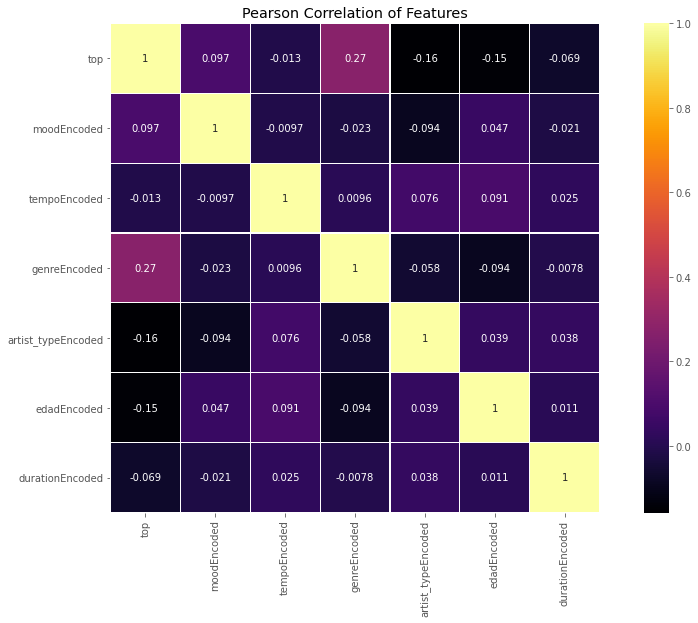

In [104]:
colormap = plt.cm.inferno
#plt.figure(figsize=(13,13))
plt.title('Pearson Correlation of Features')
sb.heatmap(artists_encoded.astype(float).corr(),
           vmax=1.0,
           cmap=colormap,
           annot=True,
           linewidths=0.1,
           linecolor='white',
           square=True)

Según esta gráfica no hay variables correlacionadas, por lo que usarlas todas en nuestro modelo nos aportará información

# Datos top en relación con los datos mapeados

In [105]:
artists_encoded[['moodEncoded', 'top']].groupby(['moodEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                 mean count sum
moodEncoded                    
0            0.000000     1   0
1            0.000000     8   0
2            0.274194    62  17
3            0.145631   103  15
4            0.136986   146  20
5            0.294872   156  46
6            0.270440   159  43

La mayoría de los top 1 están en el "mood" 5 y 6  con 46 y 43 canciones

In [107]:
artists_encoded[['artist_typeEncoded', 'top']].groupby(['artist_typeEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                        mean count sum
artist_typeEncoded                    
1                   0.305263    95  29
2                   0.320261   153  49
3                   0.162791   387  63

Hay una "buena" distribución de datos aunque se ve que mayormente están en los artistas de tipo 3 (Masculinos)

In [108]:
artists_encoded[['genreEncoded', 'top']].groupby(['genreEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                  mean count sum
genreEncoded                    
0             0.105263    19   2
1             0.070000   100   7
2             0.008850   113   1
3             0.319149   188  60
4             0.330233   215  71

Como era de esperarse la mayoría de los top estan en los genero 3 y 4 que son Urbano y Pop

In [109]:
artists_encoded[['tempoEncoded', 'top']].groupby(['tempoEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top           
                  mean count  sum
tempoEncoded                     
0             0.226415    53   12
1             0.246154    65   16
2             0.218569   517  113

De la misma manera el "tempo" con mas canciones en el top 1 es el 2, tempo medio

In [110]:
artists_encoded[['durationEncoded', 'top']].groupby(['durationEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                     mean count sum
durationEncoded                    
0.0              0.295775    71  21
1.0              0.333333    30  10
2.0              0.212963   108  23
3.0              0.202381   168  34
4.0              0.232143   112  26
5.0              0.145455    55   8
6.0              0.208791    91  19

Respecto a la duración de las canciones están bastante repartidas aunque se ve una mayoría en la duracion 3

In [112]:
artists_encoded[['edadEncoded', 'top']].groupby(['edadEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                 mean count sum
edadEncoded                    
0.0          0.261538    65  17
1.0          0.298137   161  48
2.0          0.245033   151  37
3.0          0.175355   211  37
4.0          0.042553    47   2

La gran mayoría de la edad de los artistas al llevar una cancion al top 1 es de el rango 1 que corresponde a edades entre 21 y 25 años

# Buscar los parámetros del Arbol de Decisión

KFold crea varios subgrupos del dataset para validar  valorar los arboles con diferentes niveles de profundidad

Ya que se usará el arbol de clasificacion y no de decision, entonces se construye con la libreria sklearn tree.DecisionTreeClassifier:

 - criterion: para variables categoricas se suele usar "entropy" (ganancia de infromación) o gini para variables continuas
 - min_samples_split: cantidad minima de muestras que debe tener un nodo para subdividir
 - min_samples_leaf: cantidad minima que puede tener una hoja final
 - class_weight: Compensa de cierta manera el desbalance de los datos (top 0 [494] dividido entre los top 1 [141] da 3.5)

todos estos parametros salen de prueba y error, visualizar los datos y el arbol y volver a intentar.


In [113]:
cv = KFold(n_splits=10) # Numero deseado de "folds" que haremos
accuracies = list()
max_attributes = len(list(artists_encoded))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight={1:3.5}) # Por defecto todas las clases igual peso
                                                                   # Columna 1 (top) con peso de 3.5
    for train_fold, valid_fold in cv.split(artists_encoded):
        f_train = artists_encoded.loc[train_fold] 
        f_valid = artists_encoded.loc[valid_fold] 

        model = tree_model.fit(X = f_train.drop(['top'], axis=1), 
                               y = f_train["top"]) 
        valid_acc = model.score(X = f_valid.drop(['top'], axis=1), 
                                y = f_valid["top"]) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.556101
         2          0.556126
         3          0.564038
         4          0.642535
         5          0.599975
         6          0.628373
         7          0.643998


4 niveles de profundidad porque es el mejor valor de accuracy

# se multiplica por el valor de la proporción de los top 1 y no top 1   494/141 = 3.5 esto es para darle el mismo "peso" a los datos y evitar un sesgo
con esto se evita el preprocesamiento de datos ya que el arbol permite hacer esto

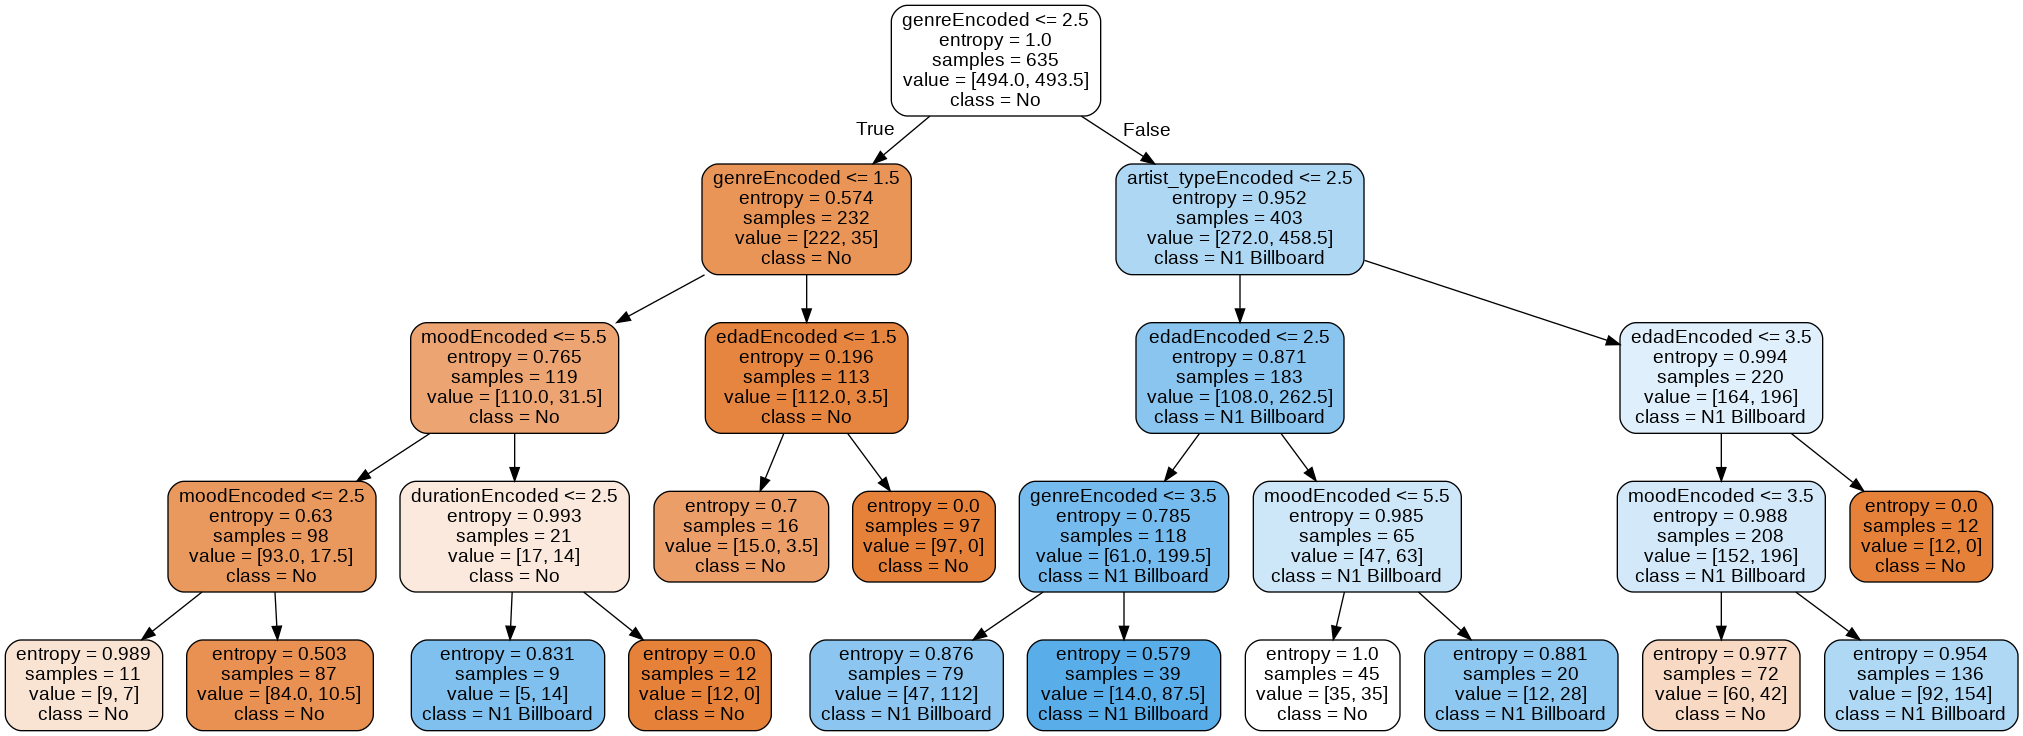

In [115]:
# Crear arrays de entrenamiento y las etiquetas que indican si llegó a top o no 
y_train = artists_encoded['top']
x_train = artists_encoded.drop(['top'], axis=1).values 

# Crear Arbol de decision con profundidad = 4
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 4,
                                            class_weight={1:3.5})
decision_tree.fit(x_train, y_train)

# exportar el modelo a archivo .dot
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 7,
                              impurity = True,
                              feature_names = list(artists_encoded.drop(['top'], axis=1)),
                              class_names = ['No', 'N1 Billboard'],
                              rounded = True,
                              filled= True )
        
# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

## Precisión del árbol

In [116]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
print(acc_decision_tree,'%')

68.82 %


In [117]:
print(artists_billboard.shape)

artists_billboard.info
 

(635, 18)


<bound method DataFrame.info of       id                       title  ... edadEncoded durationEncoded
0      0        Small Town Throwdown  ...         3.0             2.0
1      1                   Bang Bang  ...         1.0             6.0
2      2                      Timber  ...         0.0             3.0
3      3             Sweater Weather  ...         1.0             2.0
4      4                   Automatic  ...         2.0             3.0
..   ...                         ...  ...         ...             ...
630  630       The Blower's Daughter  ...         1.0             6.0
631  631                  First Love  ...         4.0             3.0
632  632                      No One  ...         1.0             1.0
633  633  She Came To Give It To You  ...         3.0             2.0
634  634                 Wasted Love  ...         1.0             3.0

[635 rows x 18 columns]>

# ver las variables principales

Text(0, 0.5, 'características')

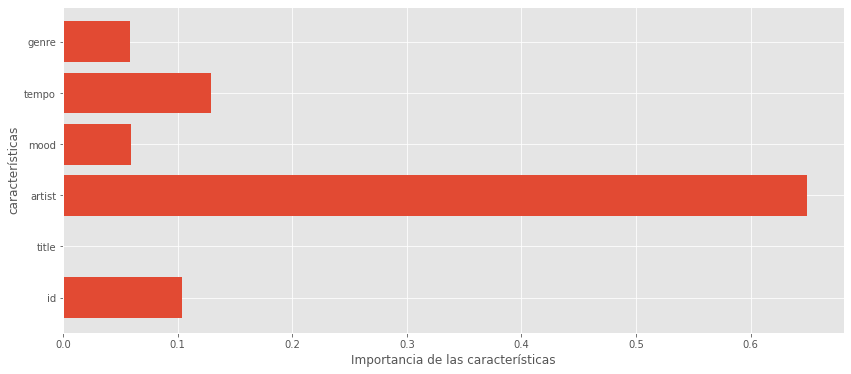

In [123]:
caract = 6
plt.figure(figsize=(14,6))
plt.barh(range(caract), decision_tree.feature_importances_)
plt.yticks(np.arange(caract), list(artists_billboard))
plt.xlabel('Importancia de las características')
plt.ylabel('características')

# Predicción del árbol de decisión

In [124]:
#predecir artista CAMILA CABELLO featuring YOUNG THUG
# con su canción Havana llego a numero 1 Billboard US en 2017

x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (1,5,2,4,1,0,3)
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(np.round(y_proba[0][y_pred]* 100, 2)) + "%")

Prediccion: [1]
Probabilidad de Acierto: [86.21]%


In [125]:
#predecir artista Imagine Dragons 
# con su canción Believer llego al puesto 42 Billboard US en 2017

x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (0,4,2,1,3,2,3)
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(np.round(y_proba[0][y_pred]* 100, 2))+"%")

Prediccion: [0]
Probabilidad de Acierto: [88.89]%
